# Methods for loading a trained agent provided by Markel

In [1]:
import json
import os

from typing import Any

from gymnasium.spaces import Box
import numpy as np

import torch

from omnisafe.common import Normalizer
from omnisafe.envs.wrapper import ActionRepeat, ActionScale, ObsNormalize, TimeLimit
from omnisafe.models.actor_critic.constraint_actor_q_critic import ConstraintActorQCritic
from omnisafe.utils.config import Config
from omnisafe.envs.core import CMDP, make
from omnisafe.algorithms.model_based.base.ensemble import EnsembleDynamicsModel
from omnisafe.models.actor import ActorBuilder
from typing import Dict, Tuple, Any


def _load_model_and_env(
    save_dir: str,
    model_name: str,
    cfgs: Config,
    env_kwargs: Dict[str, Any],
) -> None:
    """Load the model from the save directory.

    Args:
        save_dir (str): Directory where the model is saved.
        model_name (str): Name of the model.
        env_kwargs (dict[str, Any]): Keyword arguments for the environment.

    Raises:
        FileNotFoundError: If the model is not found.
    """
    # load the saved model
    model_path = os.path.join(save_dir, 'torch_save', model_name)
    try:
        model_params = torch.load(model_path)
    except FileNotFoundError as error:
        raise FileNotFoundError('The model is not found in the save directory.') from error

    # load the environment
    env = make(**env_kwargs)

    observation_space = env.observation_space
    action_space = env.action_space
    if 'Saute' in cfgs['algo'] or 'Simmer' in cfgs['algo']:
        safety_budget = (
            cfgs.algo_cfgs.safety_budget
            * (1 - cfgs.algo_cfgs.saute_gamma**cfgs.algo_cfgs.max_ep_len)
            / (1 - cfgs.algo_cfgs.saute_gamma)
            / cfgs.algo_cfgs.max_ep_len
            * torch.ones(1)
        )
    assert isinstance(observation_space, Box), 'The observation space must be Box.'
    assert isinstance(action_space, Box), 'The action space must be Box.'

    if cfgs['algo_cfgs']['obs_normalize']:
        obs_normalizer = Normalizer(shape=observation_space.shape, clip=5)
        obs_normalizer.load_state_dict(model_params['obs_normalizer'])
        env = ObsNormalize(env, device=torch.device('cpu'), norm=obs_normalizer)
    if env.need_time_limit_wrapper:
        env = TimeLimit(env, device=torch.device('cpu'), time_limit=1000)
    env = ActionScale(env, device=torch.device('cpu'), low=-1.0, high=1.0)

    if hasattr(cfgs['algo_cfgs'], 'action_repeat'):
        env = ActionRepeat(
            env,
            device=torch.device('cpu'),
            times=cfgs['algo_cfgs']['action_repeat'],
        )
    if hasattr(cfgs, 'algo') and cfgs['algo'] in [
        'LOOP',
        'SafeLOOP',
        'PETS',
        'CAPPETS',
        'RCEPETS',
        'CCEPETS',
    ]:
        dynamics_state_space = (
            env.coordinate_observation_space
            if env.coordinate_observation_space is not None
            else env.observation_space
        )
        assert env.action_space is not None and isinstance(
            env.action_space.shape,
            tuple,
        )
        if isinstance(env.action_space, Box):
            action_space = env.action_space
        else:
            raise NotImplementedError
        if cfgs['algo'] in ['LOOP', 'SafeLOOP']:
            actor_critic = ConstraintActorQCritic(
                obs_space=dynamics_state_space,
                act_space=action_space,
                model_cfgs=cfgs.model_cfgs,
                epochs=1,
            )
        if actor_critic is not None:
            actor_critic.load_state_dict(model_params['actor_critic'])
            actor_critic.to('cpu')
        dynamics = EnsembleDynamicsModel(
            model_cfgs=cfgs.dynamics_cfgs,
            device=torch.device('cpu'),
            state_shape=dynamics_state_space.shape,
            action_shape=action_space.shape,
            actor_critic=actor_critic,
            rew_func=None,
            cost_func=env.get_cost_from_obs_tensor,
            terminal_func=None,
        )
        dynamics.ensemble_model.load_state_dict(model_params['dynamics'])
        dynamics.ensemble_model.to('cpu')
        if cfgs['algo'] in ['CCEPETS', 'RCEPETS', 'SafeLOOP']:
            algo_to_planner = {
                'CCEPETS': (
                    'CCEPlanner',
                    {'cost_limit': cfgs['algo_cfgs']['cost_limit']},
                ),
                'RCEPETS': (
                    'RCEPlanner',
                    {'cost_limit': cfgs['algo_cfgs']['cost_limit']},
                ),
                'SafeLOOP': (
                    'SafeARCPlanner',
                    {
                        'cost_limit': cfgs['algo_cfgs']['cost_limit'],
                        'actor_critic': actor_critic,
                    },
                ),
            }
        elif cfgs['algo'] in ['PETS', 'LOOP']:
            algo_to_planner = {
                'PETS': ('CEMPlanner', {}),
                'LOOP': ('ARCPlanner', {'actor_critic': actor_critic}),
            }
        elif cfgs['algo'] in ['CAPPETS']:
            lagrange: torch.nn.Parameter = torch.nn.Parameter(
                model_params['lagrangian_multiplier'].to('cpu'),
                requires_grad=False,
            )
            algo_to_planner = {
                'CAPPETS': (
                    'CAPPlanner',
                    {
                        'cost_limit': cfgs['lagrange_cfgs']['cost_limit'],
                        'lagrange': lagrange,
                    },
                ),
            }
        planner_name = algo_to_planner[cfgs['algo']][0]
        planner_special_cfgs = algo_to_planner[cfgs['algo']][1]
        planner_cls = globals()[f'{planner_name}']
        planner = planner_cls(
            dynamics=dynamics,
            planner_cfgs=cfgs.planner_cfgs,
            gamma=float(cfgs.algo_cfgs.gamma),
            cost_gamma=float(cfgs.algo_cfgs.cost_gamma),
            dynamics_state_shape=dynamics_state_space.shape,
            action_shape=action_space.shape,
            action_max=1.0,
            action_min=-1.0,
            device='cpu',
            **planner_special_cfgs,
        )

    else:
        if 'Saute' in cfgs['algo'] or 'Simmer' in cfgs['algo']:
            observation_space = Box(
                low=np.hstack((observation_space.low, -np.inf)),
                high=np.hstack((observation_space.high, np.inf)),
                shape=(observation_space.shape[0] + 1,),
            )
        actor_type = cfgs['model_cfgs']['actor_type']
        pi_cfg = cfgs['model_cfgs']['actor']
        weight_initialization_mode = cfgs['model_cfgs']['weight_initialization_mode']
        actor_builder = ActorBuilder(
            obs_space=observation_space,
            act_space=action_space,
            hidden_sizes=pi_cfg['hidden_sizes'],
            activation=pi_cfg['activation'],
            weight_initialization_mode=weight_initialization_mode,
        )
        actor = actor_builder.build_actor(actor_type)
        actor.load_state_dict(model_params['pi'])

    return env, actor


def _load_cfgs(save_dir):
    cfg_path = os.path.join(save_dir, 'config.json')
    try:
        with open(cfg_path, encoding='utf-8') as file:
            kwargs = json.load(file)
    except FileNotFoundError as error:
        raise FileNotFoundError(
            f'The config file is not found in the save directory{save_dir}.',
        ) from error
    return Config.dict2config(kwargs)


# LOG_DIR should contain two things:
# 1. config.json
# 2. torch_save/{model_name}
#
# model_name usually looks like 'epoch-500.pt'
def load_guide(save_dir, model_name) -> Tuple[CMDP, ConstraintActorQCritic]:
    cfgs = _load_cfgs(save_dir)

    env_kwargs = {
        'env_id': cfgs['env_id'],
        'num_envs': 1,
    }

    env, actor = _load_model_and_env(save_dir, model_name, cfgs, env_kwargs)
    return env, actor


# Generating a dataset

In [2]:
from omnisafe.models.actor import GaussianLearningActor
import safety_gymnasium
import torch

env = safety_gymnasium.make('SafetyPointGoal1-v0', max_episode_steps=1000)

def create_random_agent(env, hidden_layers=[255,255,255,255], activation='relu', weight_initialization_mode='orthogonal'):
    obs_space = env.observation_space
    act_space = env.action_space
    return GaussianLearningActor(obs_space, act_space, hidden_layers, activation=activation, weight_initialization_mode=weight_initialization_mode)

In [3]:
env.obs_space_dict.keys()

KeysView(Dict('accelerometer': Box(-inf, inf, (3,), float64), 'velocimeter': Box(-inf, inf, (3,), float64), 'gyro': Box(-inf, inf, (3,), float64), 'magnetometer': Box(-inf, inf, (3,), float64), 'goal_lidar': Box(0.0, 1.0, (16,), float64), 'hazards_lidar': Box(0.0, 1.0, (16,), float64), 'vases_lidar': Box(0.0, 1.0, (16,), float64)))

In [4]:
env.action_space

Box(-1.0, 1.0, (2,), float64)

In [54]:
import numpy as np

def run_trajectory(env, agent, safe_agent, min_rand_steps=100, max_rand_steps=400, cost_window=200, deterministic=True):
    observation, info = env.reset()
    episode_over = False
    is_sampling = False
    sampled_cost = 0
    sampling_step = 0
    agent_instance_for_pos = env.unwrapped.__getattribute__("task").agent
    data = []
    labels = []
    # get a random number for the amount of steps the random agent should take before a sample is created
    num_steps = np.random.randint(min_rand_steps, max_rand_steps)
    # gather data
    for i in range(num_steps):
        # Discard trajectory if the agent moves out of the checkered 7x7 space, coordinates were tested manually
        if abs(agent_instance_for_pos.pos[0]) >= 3.5 or abs(agent_instance_for_pos.pos[1]) >= 3.5: 
            break
        obs_tensor = torch.from_numpy(observation).float()
        action = agent.predict(obs_tensor, deterministic=deterministic).detach().numpy()
        if i == num_steps - 1:
            data.append(np.append(observation, action)) 
        observation, reward, cost, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated
        if episode_over:
            break
    if not episode_over:
        # sample with the pre trained agent
        for i in range(cost_window):
            obs_tensor = torch.from_numpy(observation).float()
            action = safe_agent.predict(obs_tensor, deterministic=deterministic).detach().numpy()
            observation, reward, cost, terminated, truncated, info = env.step(action)
            episode_over = terminated or truncated
            sampled_cost += cost
            sampling_step += 1
            if episode_over or i == cost_window - 1:
                labels.append(sampled_cost)
                break
    if len(labels) == 0:
        # If episode ended before sampling could happen, return an empty data and labels array
        # More of a safety measure, probably obsolete
        data = []
    if len(data) == 0:
        labels = []
    env.close()
    # assertion to make sure every data point has a label
    assert len(data) == len(labels)
    return np.array(data), np.array(labels)

In [37]:
# load my saved trained agent
safe_agent = load_guide("../runs/PPOLag-{SafetyPointGoal1-v0}/seed-000-2025-05-13-17-51-08", "epoch-50.pt")[1]

/tmp/ipykernel_968/1383116929.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(model_path)


In [38]:
data, labels = run_trajectory(env, create_random_agent(env), safe_agent)
labels.shape

(1,)

In [39]:
print(labels)

[0.]


In [40]:
data.shape

(1, 62)

In [41]:
len(data)

1

In [42]:
from tqdm import tqdm

def generate_dataset(env, safe_agent, amount=1000):
    data = []
    labels = []
    for _ in tqdm(range(amount), desc="Generating data points", unit=" sample "):
        data_i = []
        while len(data_i) == 0: # Ensure that a sample is generated
            data_i, labels_i = run_trajectory(env, create_random_agent(env), safe_agent)
        data.append(data_i)
        labels.append(labels_i)
    return np.concatenate(data, axis=0)[:amount], np.concatenate(labels, axis=0)[:amount]

In [62]:
data, labels = generate_dataset(env, safe_agent, amount=100000)

Generating data points: 100%|██████████| 100000/100000 [34:24:11<00:00,  1.24s/ sample ]  


In [63]:
data

array([[-0.769528  , 11.532802  ,  9.81      , ...,  0.        ,
        -1.25018418,  0.04445577],
       [-1.78246786, -1.58724729,  9.81      , ...,  0.        ,
        -0.14957084,  1.56127739],
       [ 2.15435992,  1.39720127,  9.81      , ...,  0.        ,
         1.01796758,  1.85080564],
       ...,
       [-1.83884534,  3.34935218,  9.81      , ...,  0.        ,
        -0.72516757,  0.78899771],
       [-1.92601718, -1.2521395 ,  9.81      , ...,  0.        ,
        -1.02038395,  1.09551978],
       [ 2.16149193, -1.39934431,  9.81      , ...,  0.        ,
         0.90575391, -1.78019655]])

In [64]:
data.shape

(100000, 62)

In [65]:
labels

array([ 0.,  0.,  0., ..., 46.,  0., 16.])

In [66]:
labels.shape

(100000,)

# Preprocessing the dataset for better NN performance

In [67]:
%pip install scikit-learn scipy pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
obs_column_names = ['accelerometer0', 'accelerometer1', 'accelerometer2', 'velocimeter0', 'velocimeter1', 'velocimeter2', 'gyro0', 'gyro1', 'gyro2', 'magnetometer0', 'magnetometer1', 'magnetometer2']
for key in ['goal_lidar', 'hazards_lidar', 'vases_lidar']:
    for i in range(16):
        obs_column_names.append(key+str(i))
obs_column_names.append("action0")
obs_column_names.append("action1")
len(obs_column_names)

62

In [30]:
import pandas as pd
df = pd.DataFrame(data=data, columns=obs_column_names)
df['exp_cost'] = labels
df.head()

NameError: name 'data' is not defined

In [70]:
# save the create dataset in a pickle file
df.to_pickle("SafetyPointGoal1Dataset0.pkl")

In [1]:
# load dataset from pickle file
import pandas as pd

df = pd.read_pickle("SafetyPointGoal1Dataset0.pkl")

In [2]:
df.describe()

,accelerometer0,accelerometer1,accelerometer2,velocimeter0,velocimeter1,velocimeter2,gyro0,gyro1,gyro2,magnetometer0,...,vases_lidar9,vases_lidar10,vases_lidar11,vases_lidar12,vases_lidar13,vases_lidar14,vases_lidar15,action0,action1,exp_cost
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.0,100000.0,100000.0,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.069010,-0.001533,9.810000e+00,0.023808,0.001872,0.0,0.0,0.0,0.006035,-0.000537,...,0.053299,0.053256,0.053404,0.053087,0.052577,0.053171,0.053593,0.000356,0.003248,9.916320
std,1.926543,6.733668,1.500540e-15,0.718428,0.577444,0.0,0.0,0.0,2.374169,0.352747,...,0.152026,0.151757,0.151848,0.151066,0.150142,0.151592,0.153017,1.072705,1.115400,19.740233
min,-5.452849,-19.989003,9.810000e+00,-1.499778,-1.081251,0.0,0.0,0.0,-3.038259,-0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.609840,-4.453977,0.000000
25%,-1.879547,-1.475206,9.810000e+00,-0.453180,-0.639035,0.0,0.0,0.0,-2.815359,-0.351950,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.686058,-0.902644,0.000000
50%,0.023382,-0.015324,9.810000e+00,0.020276,0.002603,0.0,0.0,0.0,0.020454,-0.001902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006072,0.003101,0.000000
75%,2.059706,1.469249,9.810000e+00,0.504858,0.639037,0.0,0.0,0.0,2.808083,0.352273,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680545,0.902431,15.000000
max,5.351211,19.983345,9.810000e+00,1.499773,1.053874,0.0,0.0,0.0,3.039440,0.500000,...,0.933722,0.933531,0.933638,0.933393,0.932465,0.922693,0.917074,7.266669,4.720612,200.000000


In [3]:
# Seperate the dataset into data and label again
X = df.drop(columns=["exp_cost"])
y = df.exp_cost

In [39]:
# Scaling the data with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0,1))
scaled = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled, columns=obs_column_names)
scaled_X.head()

,accelerometer0,accelerometer1,accelerometer2,velocimeter0,velocimeter1,velocimeter2,gyro0,gyro1,gyro2,magnetometer0,...,vases_lidar8,vases_lidar9,vases_lidar10,vases_lidar11,vases_lidar12,vases_lidar13,vases_lidar14,vases_lidar15,action0,action1
0,0.433478,0.788590,0.50,0.133874,0.776725,0.0,0.0,0.0,0.582009,0.029088,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.338574,0.490314
1,0.339722,0.460362,0.25,0.338908,0.892061,0.0,0.0,0.0,0.998717,0.041138,...,0.492113,0.629606,0.137120,0.0,0.0,0.0,0.0,0.0,0.424049,0.655643
2,0.704106,0.535025,1.00,0.656853,0.166961,0.0,0.0,0.0,0.988933,0.333022,...,0.210128,0.780801,0.570618,0.0,0.0,0.0,0.0,0.0,0.514721,0.687201
3,0.712390,0.469264,0.25,0.641438,0.805581,0.0,0.0,0.0,0.010329,0.980087,...,0.666369,0.682326,0.015416,0.0,0.0,0.0,0.0,0.0,0.442407,0.292759
4,0.518254,0.217423,0.50,0.975002,0.368165,0.0,0.0,0.0,0.454788,0.296595,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.483764,0.500775


In [40]:
scaled_X.describe()

,accelerometer0,accelerometer1,accelerometer2,velocimeter0,velocimeter1,velocimeter2,gyro0,gyro1,gyro2,magnetometer0,...,vases_lidar8,vases_lidar9,vases_lidar10,vases_lidar11,vases_lidar12,vases_lidar13,vases_lidar14,vases_lidar15,action0,action1
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,100000.0,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.511091,0.500032,0.423175,0.507938,0.507288,0.0,0.0,0.0,0.500896,0.499463,...,0.056717,0.057083,0.057048,0.057200,0.056875,0.056385,0.057626,0.058439,0.435692,0.485823
std,0.178317,0.168458,0.247833,0.239512,0.270450,0.0,0.0,0.0,0.390636,0.352747,...,0.161911,0.162817,0.162562,0.162641,0.161846,0.161016,0.164293,0.166853,0.083307,0.121575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.330737,0.463165,0.250000,0.348918,0.207115,0.0,0.0,0.0,0.036675,0.148050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382385,0.387084
50%,0.506868,0.499687,0.250000,0.506761,0.507630,0.0,0.0,0.0,0.503268,0.498098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.436136,0.485807
75%,0.695346,0.536827,0.500000,0.668312,0.805708,0.0,0.0,0.0,0.961934,0.852273,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.488516,0.583831
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
# Divide data into train, test and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2)

In [42]:
X_train.shape

(64000, 62)

In [34]:
X_validate.shape

(16000, 62)

In [35]:
X_test.shape

(20000, 62)

In [43]:
import torch
import numpy as np
from torch.utils.data import TensorDataset

# Convert dataset into a TensorDataset
train_dataset = TensorDataset(torch.from_numpy(X_train.values.astype(np.float32)), torch.from_numpy(y_train.values.astype(np.float32)))
validation_dataset = TensorDataset(torch.from_numpy(X_validate.values.astype(np.float32)), torch.from_numpy(y_validate.values.astype(np.float32)))
test_dataset = TensorDataset(torch.from_numpy(X_test.values.astype(np.float32)), torch.from_numpy(y_test.values.astype(np.float32)))


In [44]:
from torch.utils.data import DataLoader

# Putting data into dataloaders for PyTorch
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Validating Correctness of the Dataset and Determining Important Features

In [23]:
# load dataset from pickle file
import pandas as pd

df = pd.read_pickle("SafetyPointGoal1Dataset0.pkl")

In [3]:
df.head()

,accelerometer0,accelerometer1,accelerometer2,velocimeter0,velocimeter1,velocimeter2,gyro0,gyro1,gyro2,magnetometer0,...,vases_lidar9,vases_lidar10,vases_lidar11,vases_lidar12,vases_lidar13,vases_lidar14,vases_lidar15,action0,action1,exp_cost
0,-0.769528,11.532802,9.81,-1.098218,0.577155,0.0,0.0,-0.0,0.499018,-0.470912,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1.250184,0.044456,0.0
1,-1.782468,-1.587247,9.81,-0.483206,0.823411,0.0,0.0,-0.0,3.031644,-0.458862,...,0.587877,0.128005,0.0,0.0,0.0,0.0,0.0,-0.149571,1.561277,0.0
2,2.154360,1.397201,9.81,0.470486,-0.724769,0.0,0.0,-0.0,2.972175,-0.166978,...,0.729051,0.532690,0.0,0.0,0.0,0.0,0.0,1.017968,1.850806,0.0
3,2.243852,-1.231428,9.81,0.424247,0.638764,0.0,0.0,0.0,-2.975484,0.480087,...,0.637103,0.014392,0.0,0.0,0.0,0.0,0.0,0.086816,-1.768033,0.0
4,0.146395,-11.298087,9.81,1.424790,-0.295172,0.0,0.0,0.0,-0.274193,-0.203405,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.619345,0.140426,0.0


In [11]:
%pip install scikit-learn

  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 3.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 3.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

def evaluate_column_importance_test(feature_cols, target_col, model):
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R^2 score:", r2_score(y_test, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

In [18]:
# Goal Lidars
evaluate_column_importance_test([f"goal_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.04364996046187675
Mean Squared Error: 360.5883931033093


In [ ]:
# hazard Lidars
evaluate_column_importance_test([f"hazards_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.17699489511669053
Mean Squared Error: 310.31115806616015


In [21]:
# vases Lidars
evaluate_column_importance_test([f"vases_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.03463951322605807
Mean Squared Error: 363.9857503005497


In [22]:
# accelerometer 
evaluate_column_importance_test([f"accelerometer{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: -0.00014571018091968924
Mean Squared Error: 377.10139550731884


In [23]:
# velocimeter
evaluate_column_importance_test([f"velocimeter{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: 0.00035164701039558377
Mean Squared Error: 376.91386874096736


In [25]:
# gyrometer
evaluate_column_importance_test([f"gyro{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: -9.22453413334523e-05
Mean Squared Error: 377.08123677903234


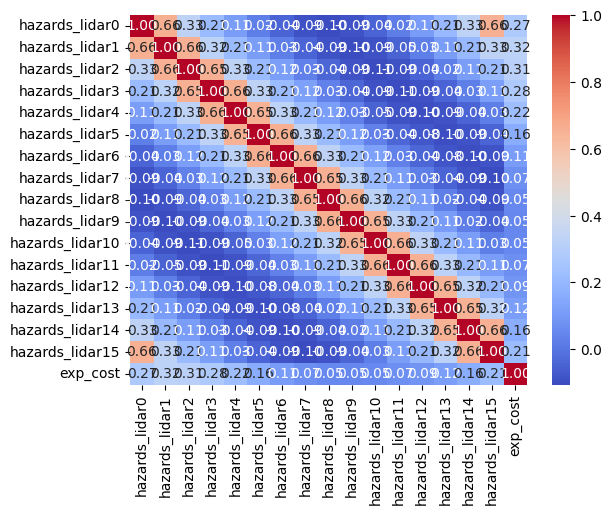

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
hazard_cols_plus_cost = [f"hazards_lidar{i}" for i in range(16)]
hazard_cols_plus_cost.append("exp_cost")
sns.heatmap(df[hazard_cols_plus_cost].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:
from sklearn.linear_model import LassoCV

X = df.drop(columns=["exp_cost"])
y = df["exp_cost"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

print("R^2:", r2_score(y_test, lasso.predict(X_test)))

# Features being none zero can indicate that the feature is important, a negative value indicates a reverse relationship (value goes up exp_cost goes down)
important_features = pd.Series(lasso.coef_, index=X.columns)
print(important_features[important_features != 0])

Best alpha: 0.0036967689856371006
R^2: 0.1808929045101234
accelerometer0    -0.075799
accelerometer1     0.003215
velocimeter0      -0.037148
velocimeter1       0.648277
gyro2              0.096063
magnetometer0      0.020087
magnetometer1      0.532916
goal_lidar0       -1.180735
goal_lidar1       -0.734166
goal_lidar2       -3.356108
goal_lidar3       -1.866430
goal_lidar4       -2.249796
goal_lidar7        0.638013
goal_lidar9        0.944522
goal_lidar11      -1.141525
goal_lidar12      -1.219026
goal_lidar13      -0.734406
goal_lidar14      -1.354813
hazards_lidar0     5.929089
hazards_lidar1     9.580229
hazards_lidar2     7.474569
hazards_lidar3     6.294225
hazards_lidar4     5.169575
hazards_lidar5     1.984693
hazards_lidar6     1.921615
hazards_lidar7     0.063223
hazards_lidar8     1.151112
hazards_lidar9     1.250939
hazards_lidar10    2.044092
hazards_lidar11    2.013728
hazards_lidar12    1.580258
hazards_lidar13    1.545846
hazards_lidar14    3.163935
hazards_lidar15   

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def max_value_plot(features, labels, polynomial_degree=1, x_name='features', y_name='exp_cost'):
    max_features = np.max(features, axis=1)
    plt.scatter(max_features, labels)

    coeffs = np.polyfit(max_features, labels, deg=polynomial_degree)
    reg_line = np.poly1d(coeffs)
    x_line = np.linspace(max_features.min(), max_features.max(), 100)
    y_line = reg_line(x_line)

    plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {polynomial_degree}')
             
    plt.xlabel(f"Maximum value of {x_name}")
    plt.ylabel(y_name)
    plt.legend()
    plt.show()

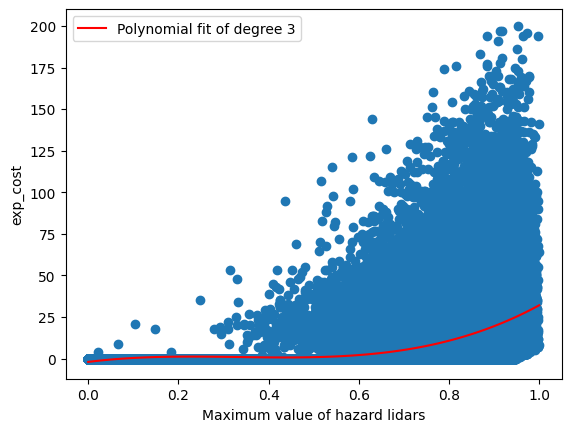

In [ ]:


hazard_cols = [f"hazards_lidar{i}" for i in range(16)]
max_value_plot(df[hazard_cols], df["exp_cost"], polynomial_degree=3, x_name="hazard lidars")

The high amount of data points with a high maximum hazard lidar value and a low expected cost can probably be explain by the high maneuverability of the Point agent.
This leads to the safe policy managing to "rescue" the agent in a lot of cases even if it is close to hazards.

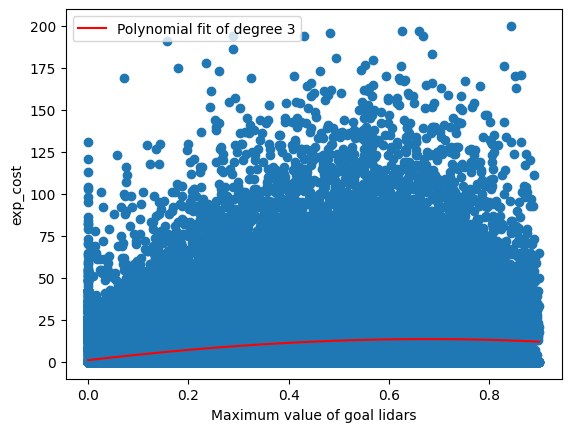

In [16]:
goal_cols = [f"goal_lidar{i}" for i in range(16)]
max_value_plot(df[goal_cols], df["exp_cost"], polynomial_degree=3, x_name="goal lidars")

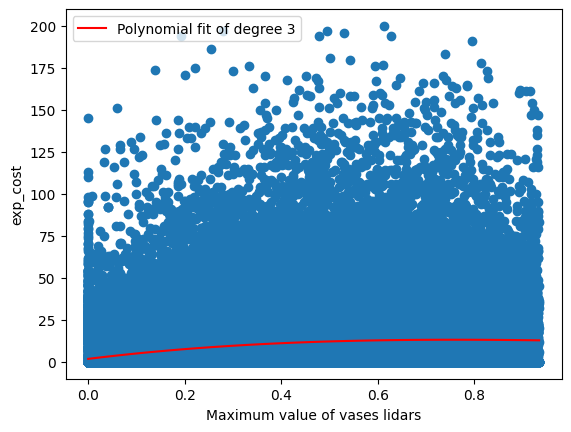

In [17]:
vases_cols = [f"vases_lidar{i}" for i in range(16)]
max_value_plot(df[vases_cols], df["exp_cost"], polynomial_degree=3, x_name="vases lidars")

These results suggest that the hazards lidar values are the most important features for predicting the expected cost. Goal and vases lidar values can maybe be even excluded from the data. 

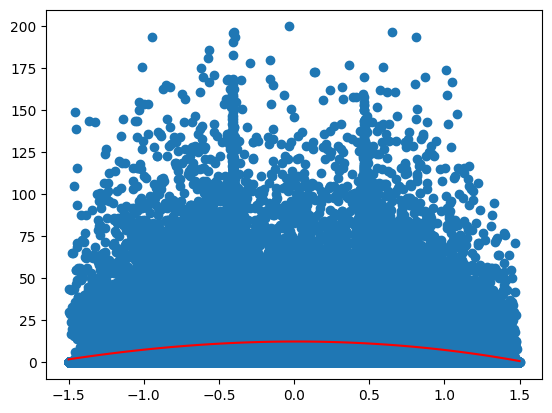

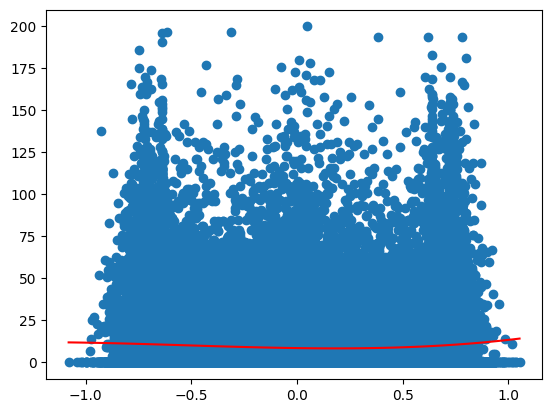

In [24]:
feature= df["velocimeter0"]
plt.scatter(feature, df["exp_cost"])

coeffs = np.polyfit(feature, df["exp_cost"], deg=3)
reg_line = np.poly1d(coeffs)
x_line = np.linspace(feature.min(), feature.max(), 100)
y_line = reg_line(x_line)

plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {3}')
plt.show()
feature= df["velocimeter1"]
plt.scatter(feature, df["exp_cost"])

coeffs = np.polyfit(feature, df["exp_cost"], deg=3)
reg_line = np.poly1d(coeffs)
x_line = np.linspace(feature.min(), feature.max(), 100)
y_line = reg_line(x_line)

plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {3}')
plt.show()

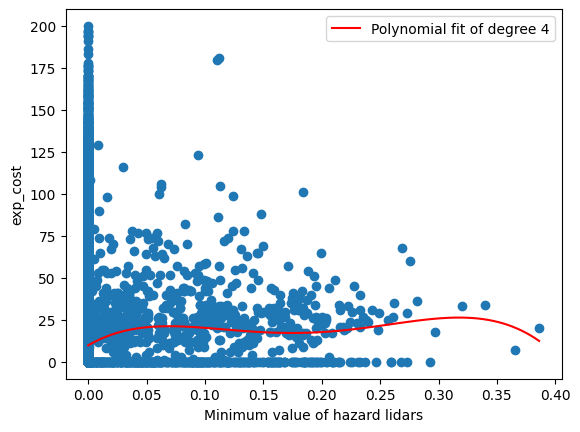

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def min_value_plot(features, labels, polynomial_degree=1, x_name='features', y_name='exp_cost'):
    min_features = np.min(features, axis=1)
    plt.scatter(min_features, labels)

    coeffs = np.polyfit(min_features, labels, deg=polynomial_degree)
    reg_line = np.poly1d(coeffs)
    x_line = np.linspace(min_features.min(), min_features.max(), 100)
    y_line = reg_line(x_line)

    plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {polynomial_degree}')
             
    plt.xlabel(f"Minimum value of {x_name}")
    plt.ylabel(y_name)
    plt.legend()
    plt.show()

hazard_cols = [f"hazards_lidar{i}" for i in range(16)]
min_value_plot(df[hazard_cols], df["exp_cost"], polynomial_degree=4, x_name="hazard lidars")

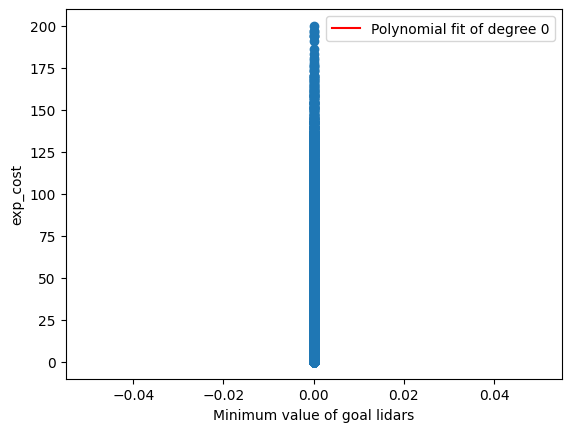

In [25]:
goal_cols = [f"goal_lidar{i}" for i in range(16)]
min_value_plot(df[goal_cols], df["exp_cost"], polynomial_degree=0, x_name="goal lidars")

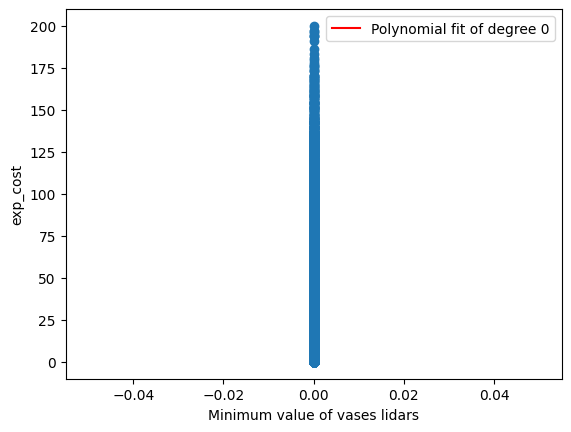

In [27]:
vases_cols = [f"vases_lidar{i}" for i in range(16)]
min_value_plot(df[vases_cols], df["exp_cost"], polynomial_degree=0, x_name="vases lidars")

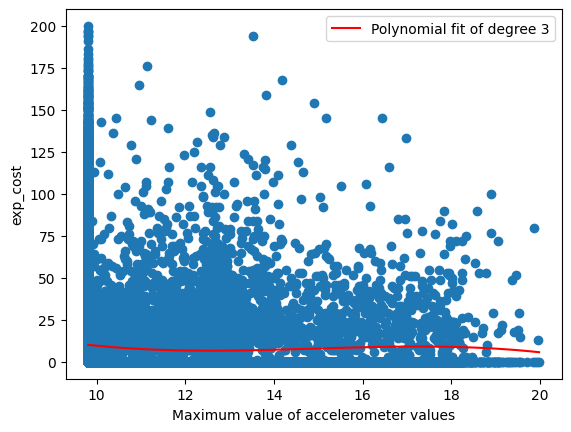

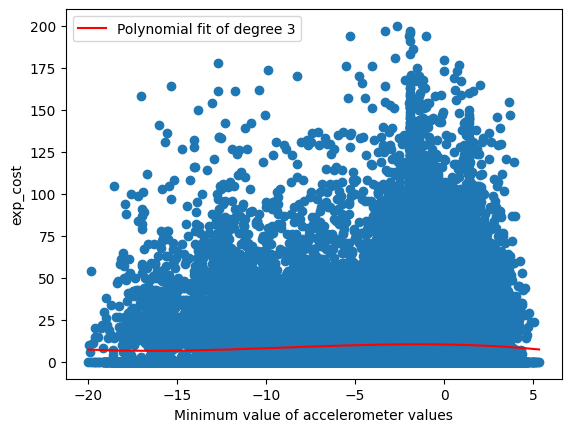

In [30]:
accel_cols = [f"accelerometer{i}" for i in range(3)]
max_value_plot(df[accel_cols], df["exp_cost"], polynomial_degree=3, x_name="accelerometer values")
min_value_plot(df[accel_cols], df["exp_cost"], polynomial_degree=3, x_name="accelerometer values")

# Creating a second dataset with lower friction and mass

I edited point.xml and changed the friction value from [1, 0.01, 0.01] to [0.5, 0.01, 0.01]

In [ ]:
from omnisafe.models.actor import GaussianLearningActor
import safety_gymnasium
import torch

env = safety_gymnasium.make('SafetyPointGoal1-v0', max_episode_steps=1000)

def create_random_agent(env, hidden_layers=[255,255,255,255], activation='relu', weight_initialization_mode='orthogonal'):
    obs_space = env.observation_space
    act_space = env.action_space
    return GaussianLearningActor(obs_space, act_space, hidden_layers, activation=activation, weight_initialization_mode=weight_initialization_mode)

In [ ]:
# load my saved trained agent
safe_agent = load_guide("../runs/PPOLag-{SafetyPointGoal1-v0}/seed-000-2025-05-13-17-51-08", "epoch-50.pt")[1]

/tmp/ipykernel_725/1383116929.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(model_path)


In [ ]:
data, labels = generate_dataset(env, safe_agent, amount=100000)

Generating data points: 100%|██████████| 100000/100000 [34:53:39<00:00,  1.26s/ sample ]  


In [ ]:
obs_column_names = ['accelerometer0', 'accelerometer1', 'accelerometer2', 'velocimeter0', 'velocimeter1', 'velocimeter2', 'gyro0', 'gyro1', 'gyro2', 'magnetometer0', 'magnetometer1', 'magnetometer2']
for key in ['goal_lidar', 'hazards_lidar', 'vases_lidar']:
    for i in range(16):
        obs_column_names.append(key+str(i))
obs_column_names.append("action0")
obs_column_names.append("action1")
len(obs_column_names)

62

In [ ]:
import pandas as pd
df = pd.DataFrame(data=data, columns=obs_column_names)
df['exp_cost'] = labels
df.head()

,accelerometer0,accelerometer1,accelerometer2,velocimeter0,velocimeter1,velocimeter2,gyro0,gyro1,gyro2,magnetometer0,...,vases_lidar9,vases_lidar10,vases_lidar11,vases_lidar12,vases_lidar13,vases_lidar14,vases_lidar15,action0,action1,exp_cost
0,-1.837957,-1.275558,9.81,-0.454794,0.661614,0.0,0.0,0.0,3.025371,-0.286820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.373583,1.447708,22.0
1,3.189097,0.853576,9.81,-0.105226,-0.086833,0.0,0.0,0.0,-2.225529,0.172595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.571393,-0.165024,25.0
2,-1.459658,-6.112409,9.81,-0.712935,0.709573,0.0,0.0,0.0,1.722741,-0.494542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.662501,0.681258,27.0
3,-0.212775,-12.735915,9.81,-1.387342,0.047581,0.0,0.0,0.0,-0.474691,0.200354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.267624,-0.029247,24.0
4,0.191312,-6.981911,9.81,1.405250,0.302957,0.0,0.0,0.0,-0.672154,0.338667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777011,-0.358056,0.0


In [ ]:
# save the create dataset in a pickle file
df.to_pickle("SafetyPointGoal1DatasetLowFriction.pkl")

Validation:

In [3]:
df = pd.read_pickle("SafetyPointGoal1DatasetLowFriction.pkl")

In [7]:
# Goal Lidars
evaluate_column_importance_test([f"goal_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.04335418229007504
Mean Squared Error: 356.77702287941764


In [8]:
# hazard Lidars
evaluate_column_importance_test([f"hazards_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.1801959276331241
Mean Squared Error: 305.7424711097884


In [9]:
# vases Lidars
evaluate_column_importance_test([f"vases_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.03883321942059503
Mean Squared Error: 358.4630969135703


In [10]:
# accelerometer 
evaluate_column_importance_test([f"accelerometer{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: -3.8296819157901396e-05
Mean Squared Error: 372.96006494718085


In [11]:
# velocimeter
evaluate_column_importance_test([f"velocimeter{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: 0.00040544720648039156
Mean Squared Error: 372.7945724843938


In [12]:
# gyrometer
evaluate_column_importance_test([f"gyro{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: -6.855608609757091e-05
Mean Squared Error: 372.97135001316184


In [13]:
from sklearn.linear_model import LassoCV

X = df.drop(columns=["exp_cost"])
y = df["exp_cost"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

print("R^2:", r2_score(y_test, lasso.predict(X_test)))

# Features being none zero can indicate that the feature is important, a negative value indicates a reverse relationship (value goes up exp_cost goes down)
important_features = pd.Series(lasso.coef_, index=X.columns)
print(important_features[important_features != 0])

R^2: 0.1828077607962948
accelerometer0    -0.133543
accelerometer1     0.013116
velocimeter0       0.042996
velocimeter1       0.383752
gyro2              0.030947
magnetometer0      0.330924
magnetometer1      0.469047
goal_lidar0       -1.108135
goal_lidar1       -0.928870
goal_lidar2       -1.403771
goal_lidar3       -2.805982
goal_lidar4       -1.072868
goal_lidar6        0.512521
goal_lidar8        1.636410
goal_lidar9        0.538077
goal_lidar12      -0.327717
goal_lidar13      -2.243747
goal_lidar14      -0.001648
goal_lidar15      -0.328498
hazards_lidar0     5.278116
hazards_lidar1     9.067394
hazards_lidar2     7.390393
hazards_lidar3     5.844197
hazards_lidar4     5.432960
hazards_lidar5     1.757754
hazards_lidar6     1.582983
hazards_lidar7     0.678220
hazards_lidar8     1.426299
hazards_lidar9     1.239018
hazards_lidar10    2.010846
hazards_lidar11    1.776725
hazards_lidar12    1.094278
hazards_lidar13    1.689061
hazards_lidar14    2.857671
hazards_lidar15    4.913

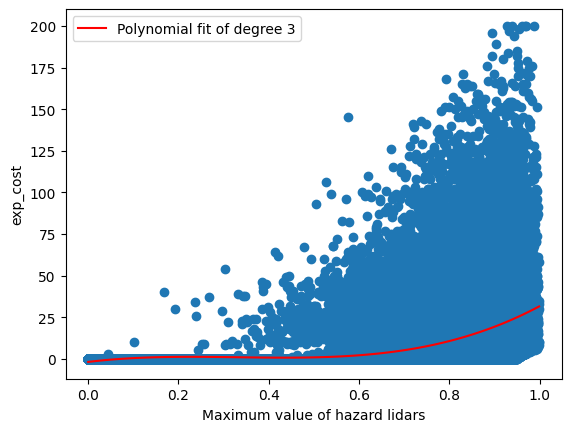

In [14]:
hazard_cols = [f"hazards_lidar{i}" for i in range(16)]
max_value_plot(df[hazard_cols], df["exp_cost"], polynomial_degree=3, x_name="hazard lidars")

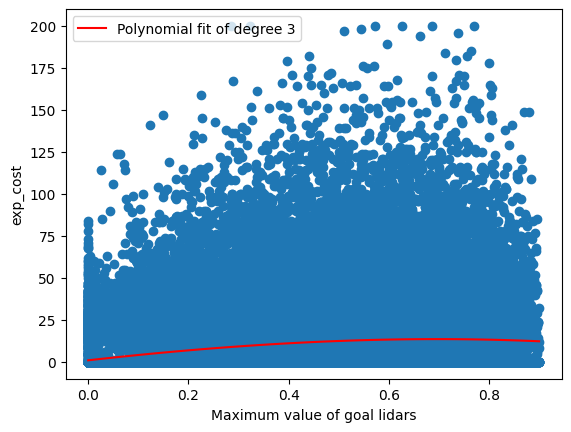

In [15]:
goal_cols = [f"goal_lidar{i}" for i in range(16)]
max_value_plot(df[goal_cols], df["exp_cost"], polynomial_degree=3, x_name="goal lidars")

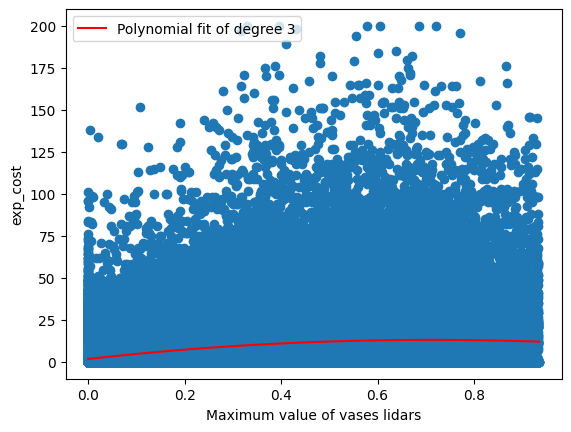

In [16]:
vases_cols = [f"vases_lidar{i}" for i in range(16)]
max_value_plot(df[vases_cols], df["exp_cost"], polynomial_degree=3, x_name="vases lidars")

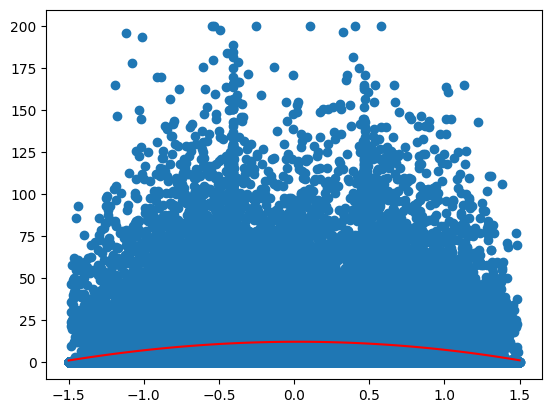

In [21]:
feature= df["velocimeter0"]
plt.scatter(feature, df["exp_cost"])

coeffs = np.polyfit(feature, df["exp_cost"], deg=3)
reg_line = np.poly1d(coeffs)
x_line = np.linspace(feature.min(), feature.max(), 100)
y_line = reg_line(x_line)

plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {3}')
plt.show()

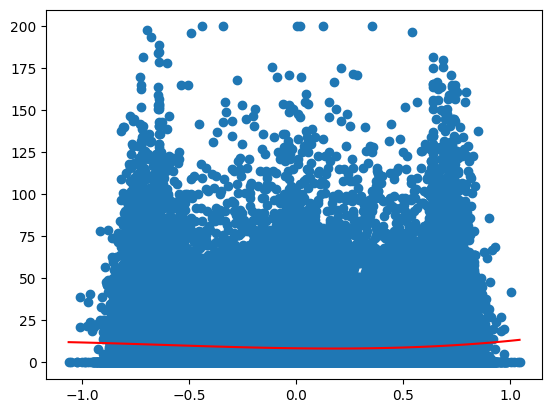

In [22]:
feature= df["velocimeter1"]
plt.scatter(feature, df["exp_cost"])

coeffs = np.polyfit(feature, df["exp_cost"], deg=3)
reg_line = np.poly1d(coeffs)
x_line = np.linspace(feature.min(), feature.max(), 100)
y_line = reg_line(x_line)

plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {3}')
plt.show()

# Building a model 

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ExpectedCostNN(nn.Module):
    def __init__(self):
        super(ExpectedCostNN, self).__init__()
        self.fc1 = nn.Linear(62, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [18]:
model = ExpectedCostNN().to(device)
print(model)

ExpectedCostNN(
  (fc1): Linear(in_features=62, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


# Training a neural network on the dataset

In [25]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [27]:
# code from https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [21]:
# code adapted to regression problem from original code https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

In [45]:
# code from https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 746.371826  [   64/64000]
loss: 256.962036  [ 6464/64000]
loss: 691.672913  [12864/64000]
loss: 264.995636  [19264/64000]
loss: 206.712311  [25664/64000]
loss: 214.502594  [32064/64000]
loss: 126.695099  [38464/64000]
loss: 531.699585  [44864/64000]
loss: 613.224731  [51264/64000]
loss: 276.619293  [57664/64000]
Avg loss: 254.240895 

Epoch 2
-------------------------------
loss: 200.639740  [   64/64000]
loss: 107.100235  [ 6464/64000]
loss: 224.904617  [12864/64000]
loss: 375.497467  [19264/64000]
loss: 209.600449  [25664/64000]
loss: 283.394104  [32064/64000]
loss: 517.227966  [38464/64000]
loss: 198.795349  [44864/64000]
loss: 366.599304  [51264/64000]
loss: 150.334122  [57664/64000]
Avg loss: 256.920621 

Epoch 3
-------------------------------
loss: 264.978302  [   64/64000]
loss: 440.101776  [ 6464/64000]
loss: 185.988739  [12864/64000]
loss: 226.073151  [19264/64000]
loss: 280.027863  [25664/64000]
loss: 268.909149  [32064/64000]
lo

# Evaluation of the model / Hyperparameter tuning